# Profile of `maze_dataset` Dumping and Loading

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pytest

from maze_dataset.dataset.maze_dataset import (
    MazeDataset,
    MazeDatasetConfig,
)
from maze_dataset.generation.generators import GENERATORS_MAP

from maze_dataset.utils import timeit_fancy

## Generate Datasets


In [2]:
cfgs = [MazeDatasetConfig(name="test", grid_n=grid_n, n_mazes=n_mazes, maze_ctor=maze_ctor, maze_ctor_kwargs=maze_ctor_kwargs, serialize_minimal_threshold=srz_threshold) 
        for grid_n, n_mazes, maze_ctor, maze_ctor_kwargs, srz_threshold in [
                (3, 1, GENERATORS_MAP['gen_dfs'], {}, 1), 
                (5, 10, GENERATORS_MAP['gen_dfs'], dict(do_forks=False), None), 
                (10, 100, GENERATORS_MAP['gen_dfs'], {}, None),
                (5, 10, GENERATORS_MAP['gen_dfs'], {}, None), 
                (5, 100, GENERATORS_MAP['gen_dfs'], {}, None), 
                (5, 1000, GENERATORS_MAP['gen_dfs'], {}, None), 
                ]]
datasets = [MazeDataset.generate(cfg) for cfg in cfgs]
old_len_cfgs = len(cfgs)  # Used in section for large dataset profiling

## Profile

In [3]:
columns=['grid_n', 'n_mazes', 'serialize', 'serialize_minimal', 'load', 'load_minimal', 'save', 'save_minimal', 'read', 'read_minimal']
speeds = pd.DataFrame(np.zeros([len(cfgs), len(columns)]), columns=columns)
speeds.grid_n = [c.grid_n for c in cfgs]
speeds.n_mazes = [c.n_mazes for c in cfgs]

## Profile small datasets only

In [4]:
for i, d in enumerate(datasets):
    print(f'Profiling: {d.cfg}')
    d.cfg.serialize_minimal_threshold = None
    speeds.loc[i, 'serialize']        , s    = timeit_fancy(d.serialize, get_return=True)
    speeds.loc[i, 'serialize_minimal'], smin = timeit_fancy(d.serialize_minimal, get_return=True)
    speeds.loc[i, 'load']                    = timeit_fancy(lambda: MazeDataset.load(s))
    speeds.loc[i, 'load_minimal']            = timeit_fancy(lambda: MazeDataset.load(smin))
    p = os.path.abspath(os.path.join(os.getcwd(), '..', 'data',d.cfg.to_fname()+'.zanj'))
    p_min = os.path.abspath(os.path.join(os.getcwd(), '..', 'data',d.cfg.to_fname()+'_min.zanj'))
    speeds.loc[i, 'save']                    = timeit_fancy(lambda: d.save(file_path=p))
    speeds.loc[i, 'read'], rt                = timeit_fancy(lambda: MazeDataset.read(file_path=p), get_return=True)
    d.cfg.serialize_minimal_threshold = 1
    speeds.loc[i, 'save_minimal']            = timeit_fancy(lambda: d.save(file_path=p_min))
    speeds.loc[i, 'read_minimal'], rt_min    = timeit_fancy(lambda: MazeDataset.read(file_path=p_min), get_return=True)
    d.cfg.serialize_minimal_threshold = None
    # rt
    # !rm {p} {p_min}
    

Profiling: MazeDatasetConfig(name='test', seq_len_min=1, seq_len_max=512, seed=42, applied_filters=[], grid_n=3, n_mazes=1, maze_ctor=<function LatticeMazeGenerators.gen_dfs at 0x0000028854782B00>, maze_ctor_kwargs={}, serialize_minimal_threshold=1)
Profiling: MazeDatasetConfig(name='test', seq_len_min=1, seq_len_max=512, seed=42, applied_filters=[], grid_n=5, n_mazes=10, maze_ctor=<function LatticeMazeGenerators.gen_dfs at 0x0000028854782B00>, maze_ctor_kwargs={'do_forks': False}, serialize_minimal_threshold=None)
Profiling: MazeDatasetConfig(name='test', seq_len_min=1, seq_len_max=512, seed=42, applied_filters=[], grid_n=10, n_mazes=100, maze_ctor=<function LatticeMazeGenerators.gen_dfs at 0x0000028854782B00>, maze_ctor_kwargs={}, serialize_minimal_threshold=None)
Profiling: MazeDatasetConfig(name='test', seq_len_min=1, seq_len_max=512, seed=42, applied_filters=[], grid_n=5, n_mazes=10, maze_ctor=<function LatticeMazeGenerators.gen_dfs at 0x0000028854782B00>, maze_ctor_kwargs={}, ser

### Results

In [22]:
max_ind, max_n = np.argmax(speeds.n_mazes.values), np.max(speeds.n_mazes.values)
print(f'{max_n} mazes:')
for c_i in range(2, 10, 2):
    advantage = speeds.iloc[max_ind, c_i] / speeds.iloc[max_ind, c_i+1]
    print('`{}`: \tminimal/standard speedup: {:3.1f}x'.format(speeds.columns[c_i], advantage))
    pass
# a = 2.1234
# print(f'{a}')

1000 mazes:
`serialize`: 	minimal/standard speedup: 0.1x
`load`: 	minimal/standard speedup: 7.2x
`save`: 	minimal/standard speedup: 2.3x
`read`: 	minimal/standard speedup: 29.7x


## Profile Large Datasets
This section should be skipped during the CI autoruns since running timing on large datasets takes awhile. An exception is raised so that execution stops and the cell outputs below are preserved. The outputs are for reference and manual rerun after further updates to `serialize`, `load`, `save`, etc. To manually rerun with all the datasets, just comment out the cell below first. Run, then uncomment it again before merging.

In [23]:
import sys
sys.exit(0)

SystemExit: 0

c:\Users\Aaron\AppData\Local\pypoetry\Cache\virtualenvs\maze-dataset-zQQMZP3O-py3.10\lib\site-packages\IPython\core\interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [24]:
assert False

AssertionError: 

In [ ]:
cfgs.append(
    [MazeDatasetConfig(name="test", grid_n=grid_n, n_mazes=n_mazes, maze_ctor=maze_ctor, maze_ctor_kwargs=maze_ctor_kwargs, serialize_minimal_threshold=srz_threshold) 
        for grid_n, n_mazes, maze_ctor, maze_ctor_kwargs, srz_threshold in [
            (5, 10000, GENERATORS_MAP['gen_dfs'], {}, None), 
        ]
    ]
)
datasets.append([MazeDataset.generate(cfg) for cfg in cfgs])

In [19]:
for i, d in enumerate(datasets):
    if i < old_len_cfgs: continue  # No need to rerun small datasets
    print(d.cfg)
    d.cfg.serialize_minimal_threshold = None
    speeds.loc[i, 'serialize']        , s    = timeit_fancy(d.serialize, get_return=True)
    speeds.loc[i, 'serialize_minimal'], smin = timeit_fancy(d.serialize_minimal, get_return=True)
    speeds.loc[i, 'load']                    = timeit_fancy(lambda: MazeDataset.load(s))
    speeds.loc[i, 'load_minimal']            = timeit_fancy(lambda: MazeDataset.load(smin))
    p = os.path.abspath(os.path.join(os.getcwd(), '..', 'data',d.cfg.to_fname()+'.zanj'))
    p_min = os.path.abspath(os.path.join(os.getcwd(), '..', 'data',d.cfg.to_fname()+'_min.zanj'))
    speeds.loc[i, 'save']                    = timeit_fancy(lambda: d.save(file_path=p))
    speeds.loc[i, 'read'], rt                = timeit_fancy(lambda: MazeDataset.read(file_path=p), get_return=True)
    d.cfg.serialize_minimal_threshold = 1
    speeds.loc[i, 'save_minimal']            = timeit_fancy(lambda: d.save(file_path=p_min))
    speeds.loc[i, 'read_minimal'], rt_min    = timeit_fancy(lambda: MazeDataset.read(file_path=p_min), get_return=True)
    d.cfg.serialize_minimal_threshold = None    

MazeDatasetConfig(name='test', seq_len_min=1, seq_len_max=512, seed=42, applied_filters=[{'name': 'collect_generation_meta', 'args': (), 'kwargs': {}}, {'name': 'collect_generation_meta', 'args': (), 'kwargs': {}}, {'name': 'collect_generation_meta', 'args': (), 'kwargs': {}}, {'name': 'collect_generation_meta', 'args': (), 'kwargs': {}}, {'name': 'collect_generation_meta', 'args': (), 'kwargs': {}}], grid_n=3, n_mazes=2, maze_ctor=<function LatticeMazeGenerators.gen_dfs at 0x0000024A0F282B00>, maze_ctor_kwargs={}, serialize_minimal_threshold=1)
MazeDatasetConfig(name='test', seq_len_min=1, seq_len_max=512, seed=42, applied_filters=[], grid_n=5, n_mazes=10, maze_ctor=<function LatticeMazeGenerators.gen_dfs at 0x0000024A0F282B00>, maze_ctor_kwargs={'do_forks': False}, serialize_minimal_threshold=None)
MazeDatasetConfig(name='test', seq_len_min=1, seq_len_max=512, seed=42, applied_filters=[], grid_n=5, n_mazes=10, maze_ctor=<function LatticeMazeGenerators.gen_dfs at 0x0000024A0F282B00>, 

### Results

In [20]:
speeds

,grid_n,n_mazes,serialize,serialize_minimal,load,load_minimal,save,save_minimal,read,read_minimal
0,3,2,0.007341,0.023264,0.019057,0.018557,0.093729,0.110137,0.023215,0.023663
1,5,10,0.007378,0.025558,0.022356,0.021118,0.109744,0.115641,0.033147,0.023552
2,5,10,0.007235,0.025768,0.023083,0.019960,0.118548,0.117720,0.044512,0.024310
3,5,100,0.008740,0.054415,0.065246,0.021663,0.355228,0.145388,0.228581,0.026695
4,5,1000,0.025394,0.345625,0.469798,0.069682,1.021488,0.464712,2.260072,0.076726
5,5,10000,0.179658,3.260850,4.735393,0.559296,9.562461,3.761656,22.448630,0.592257
6,10,1000,0.025322,0.374274,0.530957,0.079147,2.757106,0.568255,7.657044,0.101128


Comparing lines 4 and 6, it appears that the `grid_n` has a relatively small effect on `serialize` and `load` runtimes. Those functions appear to run in $O(n_{\mathrm{mazes}})$ time. `grid_n` does impact `save` and `read`, but not their `_minimal` counterparts as much.

To compare the speed of analogous procedures vs `n_mazes`, the plots below show data from `speeds.loc[2:5,:]`.

Text(0, 0.5, 'Runtime [sec]')

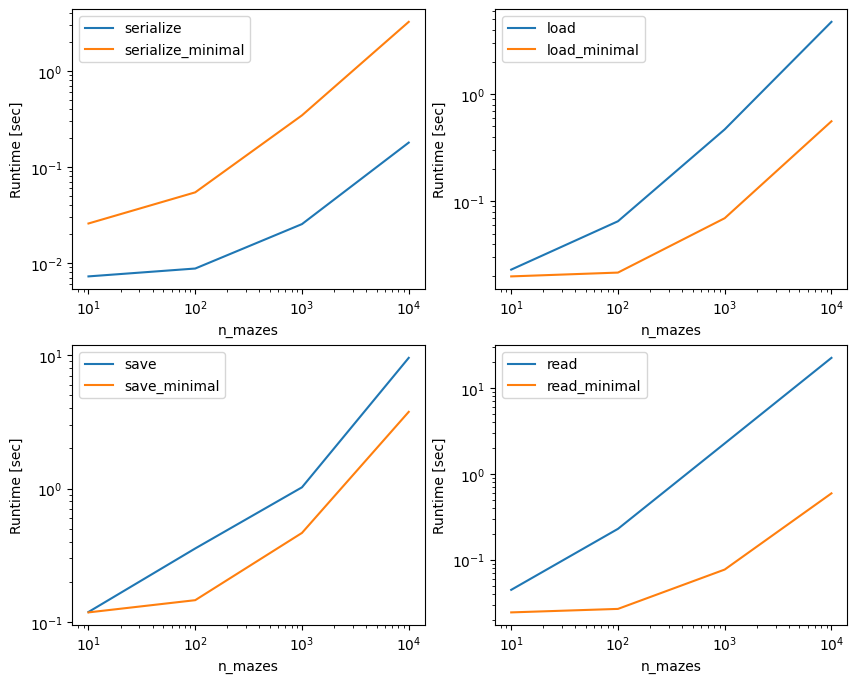

In [21]:
fig = plt.figure(figsize=(10,8))
fig.subplots(2,2)
ax = fig.axes[0]
speeds.loc[3:, ['n_mazes', 'serialize', 'serialize_minimal']].plot(x='n_mazes', ax=ax, logx=True, logy=True)
ax.set_ylabel('Runtime [sec]')

ax = fig.axes[1]
speeds.loc[3:, ['n_mazes', 'load', 'load_minimal']].plot(x='n_mazes', ax=ax, logx=True, logy=True)
ax.set_ylabel('Runtime [sec]')

ax = fig.axes[2]
speeds.loc[3:, ['n_mazes', 'save', 'save_minimal']].plot(x='n_mazes', ax=ax, logx=True, logy=True)
ax.set_ylabel('Runtime [sec]')

ax = fig.axes[3]
speeds.loc[3:, ['n_mazes', 'read', 'read_minimal']].plot(x='n_mazes', ax=ax, logx=True, logy=True)
ax.set_ylabel('Runtime [sec]')